In [1]:
#Importing the required libraries

import numpy as np 
import pandas as pd 
import plotly.express as px
from scipy.stats import chi2_contingency
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
#Reading the articles data set and storing in data frame containing article information

df = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv')

In [3]:
#Displaying basic information about the DataFrame 'df' 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [4]:
#Reading the customers data set and storing in data frame containing customer information

df_customers = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv')

In [5]:
#Displaying basic information about the DataFrame 'df_customers'

df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [6]:
#Reading the transactions data set and storing in data frame containing transaction information

df_transaction_train = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')

In [7]:
#Displaying basic information about the DataFrame 'df_transaction_train'

df_transaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [8]:
#Merging the articles and transactions data on article_id

merged_df = df_transaction_train.merge(df, on='article_id', validate='many_to_one')

In [9]:
#Merging customers data with merged_df on customer_id

merged_df = merged_df.merge(df_customers,on='customer_id',validate='many_to_one')

In [10]:
#Keeping only required columns for analysis

selected_columns = ['t_dat','customer_id','article_id','price','sales_channel_id','product_type_name','colour_group_name','perceived_colour_value_name',
                   'department_name','index_name','index_group_name','section_name','garment_group_name',
                   'club_member_status','fashion_news_frequency','age','postal_code']

# Select only the desired columns
merged_df = merged_df[selected_columns]

In [11]:
#Converting 't_dat' to datetime
merged_df['t_dat'] = pd.to_datetime(merged_df['t_dat'])

#Converting 'price' to float
merged_df['price'] = merged_df['price'].astype(float)

#Converting 'age' to int
merged_df['age'] = merged_df['age'].astype(float)

#Converting all other columns to string
columns_to_convert_to_string = ['customer_id', 'article_id', 'sales_channel_id', 'product_type_name', 'colour_group_name', 'perceived_colour_value_name',
                                'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'club_member_status',
                                'fashion_news_frequency', 'postal_code']

merged_df[columns_to_convert_to_string] = merged_df[columns_to_convert_to_string].astype(str)

In [12]:
column_data_types = merged_df.dtypes

# Printing the columns and their data types
print(column_data_types)

t_dat                          datetime64[ns]
customer_id                            object
article_id                             object
price                                 float64
sales_channel_id                       object
product_type_name                      object
colour_group_name                      object
perceived_colour_value_name            object
department_name                        object
index_name                             object
index_group_name                       object
section_name                           object
garment_group_name                     object
club_member_status                     object
fashion_news_frequency                 object
age                                   float64
postal_code                            object
dtype: object


In [13]:
del selected_columns
del column_data_types
del columns_to_convert_to_string
gc.collect()

0

In [14]:
#Describing price variable for segmentation in low, medium and high valued customer
merged_df['price'].describe()

count    3.178832e+07
mean     2.782927e-02
std      1.918113e-02
min      1.694915e-05
25%      1.581356e-02
50%      2.540678e-02
75%      3.388136e-02
max      5.915254e-01
Name: price, dtype: float64

In [15]:
#Calculating the quartiles for "price" in the merged_df DataFrame
quantiles = merged_df['price'].quantile([0.25, 0.50, 0.75])
q1, q2, q3 = quantiles[0.25], quantiles[0.50], quantiles[0.75]

#Creating bins and labels for segmentation
bins = [-np.inf, q1, q2, np.inf]
labels = ["Low-Value Customer", "Medium-Value Customer", "High-Value Customer"]

#Assigning Monetary Facet segments based on the price
merged_df['Monetary_Segment'] = pd.cut(merged_df['price'], bins=bins, labels=labels)

#Displaying the resulting DataFrame with the Monetary Facet segments
print(merged_df[['customer_id', 'price', 'Monetary_Segment']])

                                                customer_id     price  \
0         000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.050831   
1         000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.050831   
2         000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.030492   
3         000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.013542   
4         000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.022017   
...                                                     ...       ...   
31788319  45a78e9b050490ff3a368eb8b1a5c2a02899518d54f04a...  0.059305   
31788320  45a78e9b050490ff3a368eb8b1a5c2a02899518d54f04a...  0.059305   
31788321  45a78e9b050490ff3a368eb8b1a5c2a02899518d54f04a...  0.059305   
31788322  213328c37a4dec26427e7fa7fde54b8bb5e6550135629a...  0.007610   
31788323  b834a2cb440d2298493d254196abb73e101d8b35b155c6...  0.061000   

               Monetary_Segment  
0           High-Value Customer  
1           High-Value Customer  
2           High-Valu

In [16]:
#Extracting the year from the 't_dat' column
merged_df['year'] = merged_df['t_dat'].dt.year

#Group by year and color, then count unique article IDs
top_colors_by_year = merged_df.groupby(['year', 'colour_group_name'])['article_id'].nunique().reset_index()

#Get the top 5 colors for each year
top_5_colors_by_year = top_colors_by_year.groupby('year').apply(lambda x: x.nlargest(5, 'article_id')).reset_index(drop=True)

#Printing the top 5 colors for each year
for year, group in top_5_colors_by_year.groupby('year'):
    print(f'Most Common Colors in H&M Inventory in Year {year}:')
    print(group[['colour_group_name', 'article_id']])
    print()


Most Common Colors in H&M Inventory in Year 2018:
  colour_group_name  article_id
0             Black       10078
1         Dark Blue        5458
2             White        3699
3        Light Pink        2161
4              Grey        2109

Most Common Colors in H&M Inventory in Year 2019:
  colour_group_name  article_id
5             Black       15812
6         Dark Blue        8772
7             White        6515
8        Light Pink        3693
9              Grey        3177

Most Common Colors in H&M Inventory in Year 2020:
   colour_group_name  article_id
10             Black       13947
11         Dark Blue        6057
12             White        5727
13        Light Pink        3151
14       Light Beige        2316



/tmp/ipykernel_19/1493854510.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data_year['colour_group_name'], rotation=45, ha='right')


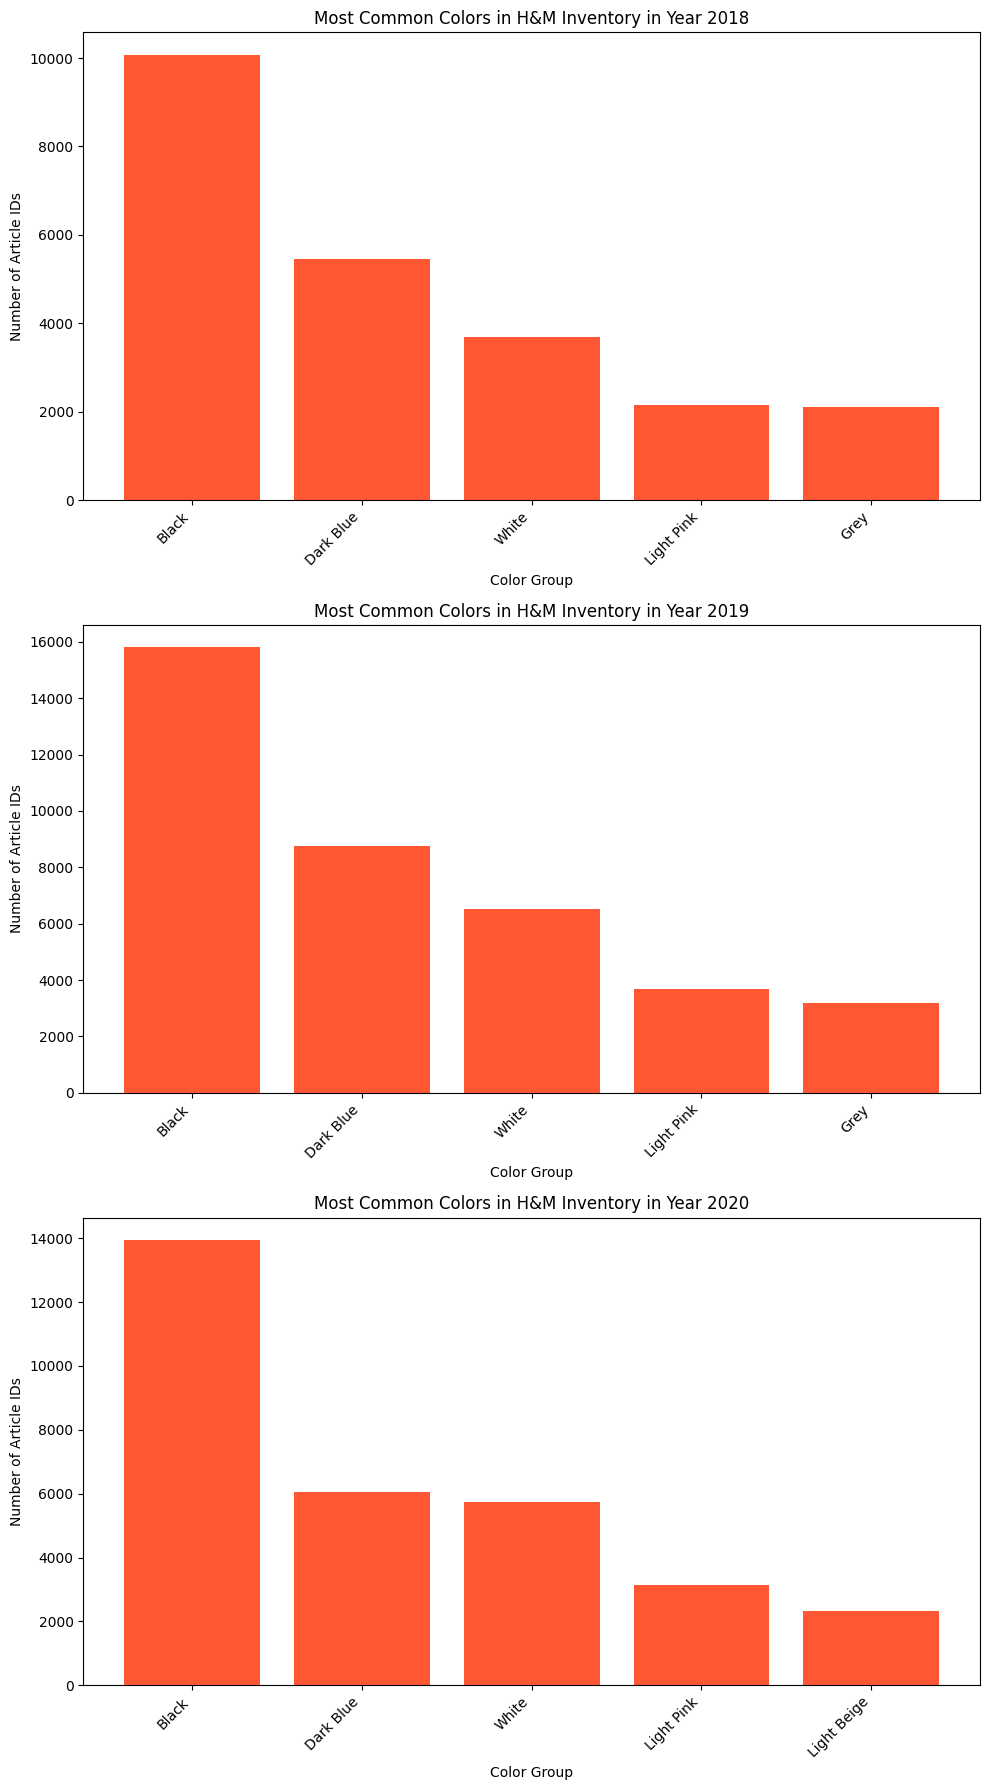

In [17]:
#Creating subplots for each year
fig, axes = plt.subplots(nrows=len(top_5_colors_by_year['year'].unique()), figsize=(10, 6 * len(top_5_colors_by_year['year'].unique())))

#Specifying the color
bar_color = '#FF5733'

#Iterating through each year and plot the top 5 colors
for i, year in enumerate(top_5_colors_by_year['year'].unique()):
    ax = axes[i]
    data_year = top_5_colors_by_year[top_5_colors_by_year['year'] == year]
    
    ax.bar(data_year['colour_group_name'], data_year['article_id'], color=bar_color)
    ax.set_title(f'Most Common Colors in H&M Inventory in Year {year}')
    ax.set_xlabel('Color Group')
    ax.set_ylabel('Number of Article IDs')
    ax.set_xticklabels(data_year['colour_group_name'], rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

In [18]:
#Group by year and category, then count unique article IDs
top_categories_by_year = merged_df.groupby(['year', 'product_type_name'])['article_id'].nunique().reset_index()

#Get the top 5 categories for each year
top_5_categories_by_year = top_categories_by_year.groupby('year').apply(lambda x: x.nlargest(5, 'article_id')).reset_index(drop=True)

#Printing the top 5 categories for each year
for year, group in top_5_categories_by_year.groupby('year'):
    print(f'Top 5 Product Types offered by H&M in Year {year}:')
    print(group[['product_type_name', 'article_id']])
    print()

Top 5 Product Types offered by H&M in Year 2018:
  product_type_name  article_id
0          Trousers        4805
1           Sweater        4626
2             Dress        3554
3           T-shirt        3161
4            Blouse        1867

Top 5 Product Types offered by H&M in Year 2019:
  product_type_name  article_id
5          Trousers        7708
6           Sweater        6632
7             Dress        6621
8           T-shirt        5150
9            Blouse        2867

Top 5 Product Types offered by H&M in Year 2020:
   product_type_name  article_id
10          Trousers        6604
11             Dress        6535
12           Sweater        4697
13           T-shirt        4209
14            Shorts        2571



/tmp/ipykernel_19/2214297717.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data_year['product_type_name'], rotation=45, ha='right')


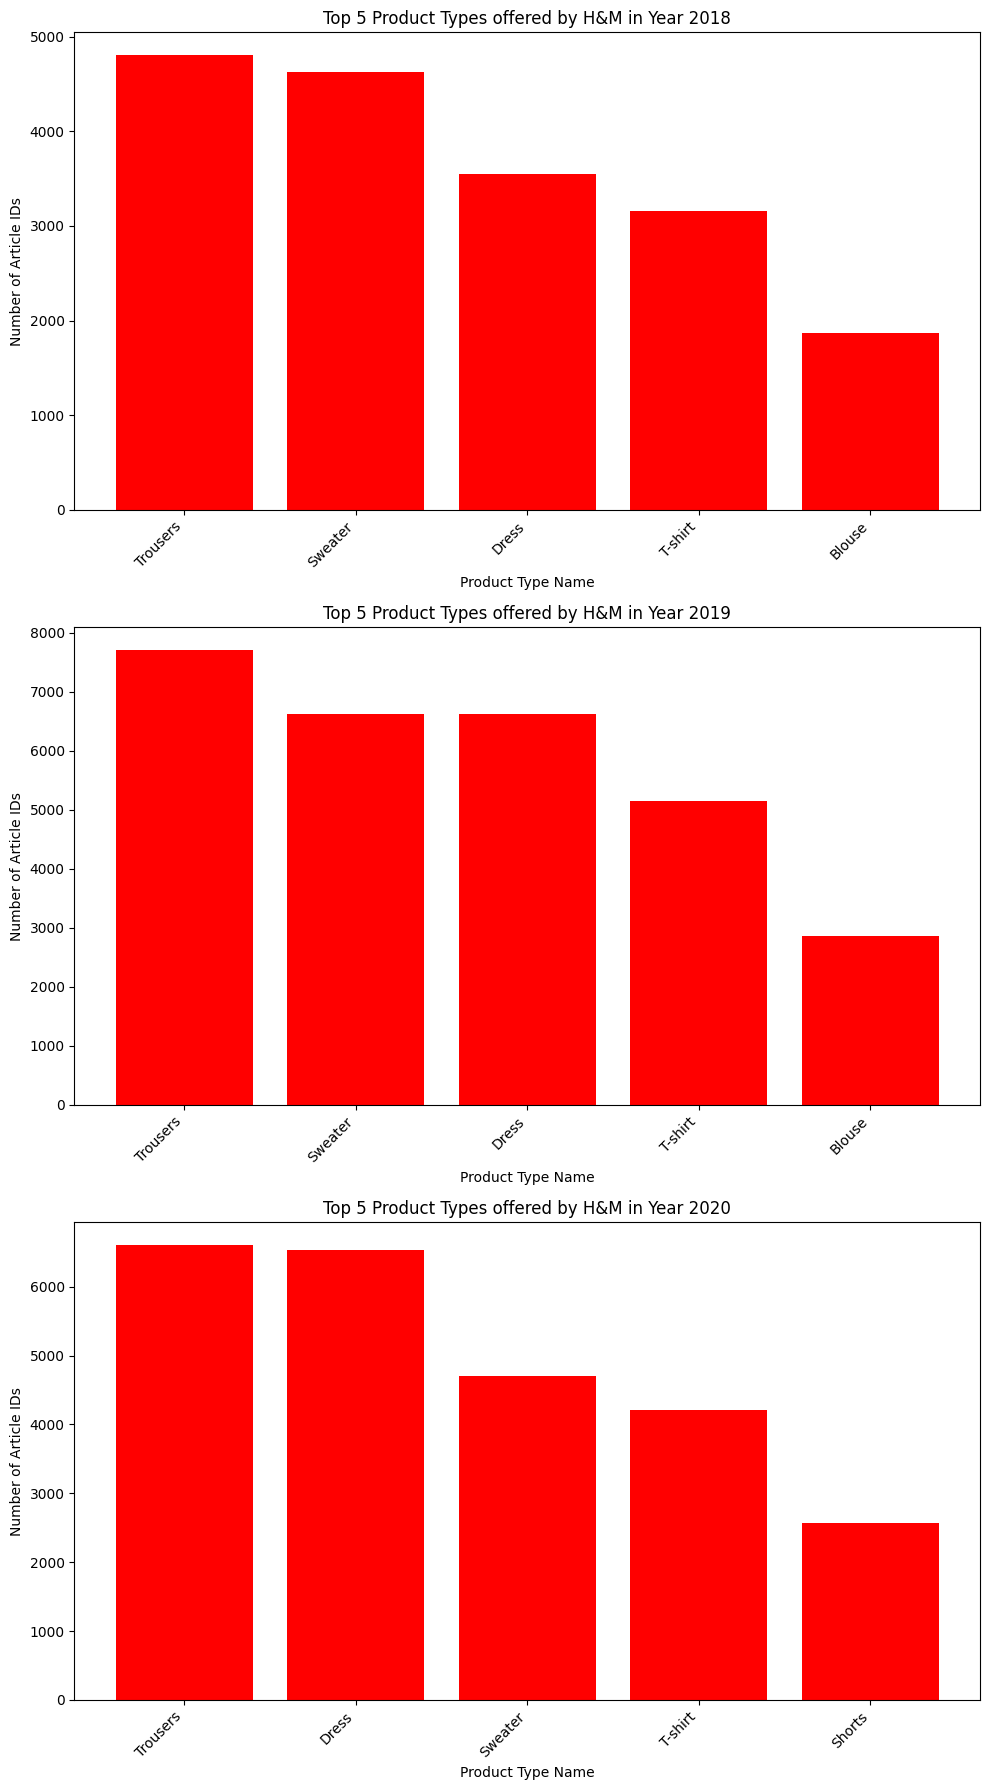

In [19]:
#Creating subplots for each year
fig, axes = plt.subplots(nrows=len(top_5_categories_by_year['year'].unique()), figsize=(10, 6 * len(top_5_categories_by_year['year'].unique())))

#Specify the color
bar_color = 'red'

#Iterating through each year and plot the top 5 categories
for i, year in enumerate(top_5_categories_by_year['year'].unique()):
    ax = axes[i]
    data_year = top_5_categories_by_year[top_5_categories_by_year['year'] == year]
    
    ax.bar(data_year['product_type_name'], data_year['article_id'], color=bar_color)
    ax.set_title(f'Top 5 Product Types offered by H&M in Year {year}')
    ax.set_xlabel('Product Type Name')
    ax.set_ylabel('Number of Article IDs')
    ax.set_xticklabels(data_year['product_type_name'], rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

In [20]:
del top_colors_by_year
del top_5_colors_by_year
del top_categories_by_year
del top_5_categories_by_year
gc.collect()

9655

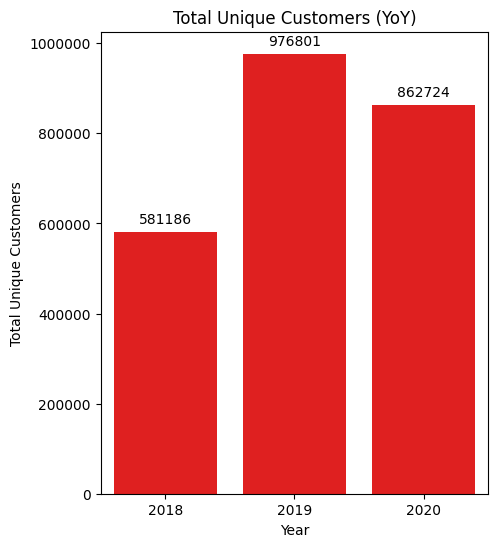

In [21]:
#Grouping the data by year and calculating the total unique customers for each year
unique_customers_yoy = merged_df.groupby('year')['customer_id'].nunique().reset_index()

#Calculating the YoY change in the number of unique customers
unique_customers_yoy['yoy_change'] = unique_customers_yoy['customer_id'].pct_change()
# Create a figure with subplots for the bar chart
fig, ax1 = plt.subplots(1, 1, figsize=(5, 6))

#Bar chart for total unique customers
sns.barplot(data=unique_customers_yoy, x='year', y='customer_id', ax=ax1, color='red')
ax1.set_title('Total Unique Customers (YoY)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Unique Customers')

#Adding numbers on top of bars
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#Format the y-axis labels as regular numbers
ax1.get_yaxis().get_major_formatter().set_scientific(False)

#Show the plot
plt.show()

In [22]:
unique_customers_yoy

,year,customer_id,yoy_change
0,2018,581186,NaN
1,2019,976801,0.680703
2,2020,862724,-0.116786


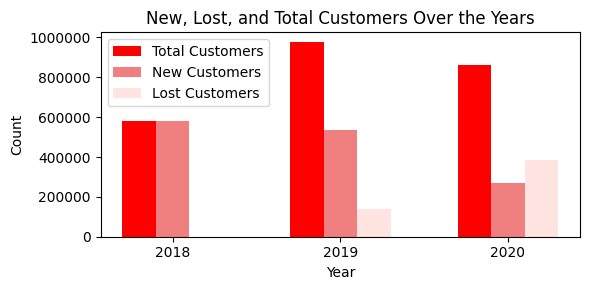

In [23]:
#Sorting the DataFrame by 'year' and 'customer_id'
merged_df.sort_values(by=['year', 'customer_id'], inplace=True)

#Initializing variables to keep track of previous year's customers
previous_year_customers = set()

#Creating lists to store the results for plotting
years = []
new_customers_count = []
lost_customers_count = []
total_customers_count = []

#Iterating through each year
for year in merged_df['year'].unique():
    current_year_customers = set(merged_df[merged_df['year'] == year]['customer_id'])
    
    #Calculating new customers (present in the current year but not in the previous year)
    new_customers = current_year_customers - previous_year_customers
    
    #Calculating lost customers (present in the previous year but not in the current year)
    lost_customers = previous_year_customers - current_year_customers
    
    #Updating previous_year_customers for the next iteration
    previous_year_customers = current_year_customers
    
    #Storing the results for plotting
    years.append(year)
    new_customers_count.append(len(new_customers))
    lost_customers_count.append(len(lost_customers))
    
    #Calculating the total customers for the current year
    total_customers_count.append(len(current_year_customers))

#Creating a DataFrame for plotting
plot_data = pd.DataFrame({'Year': years, 'New Customers': new_customers_count, 'Lost Customers': lost_customers_count, 'Total Customers': total_customers_count})

#Creating a grouped bar chart using Matplotlib
plt.figure(figsize=(6, 3))
width = 0.2  # Width of each bar
x = range(len(years))

#Solid red for total customers
plt.bar(x, total_customers_count, width, label='Total Customers', color='red')

#Light red for new customers
plt.bar([i + width for i in x], new_customers_count, width, label='New Customers', color='lightcoral')

#Lightest red for lost customers
plt.bar([i + width * 2 for i in x], lost_customers_count, width, label='Lost Customers', color='mistyrose')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('New, Lost, and Total Customers Over the Years')
plt.xticks([i + width for i in x], years)  #Setting x-axis labels to years
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
plot_data

,Year,New Customers,Lost Customers,Total Customers
0,2018,581186,0,581186
1,2019,535691,140076,976801
2,2020,268811,382888,862724


In [25]:
del unique_customers_yoy
del plot_data
gc.collect()

3637

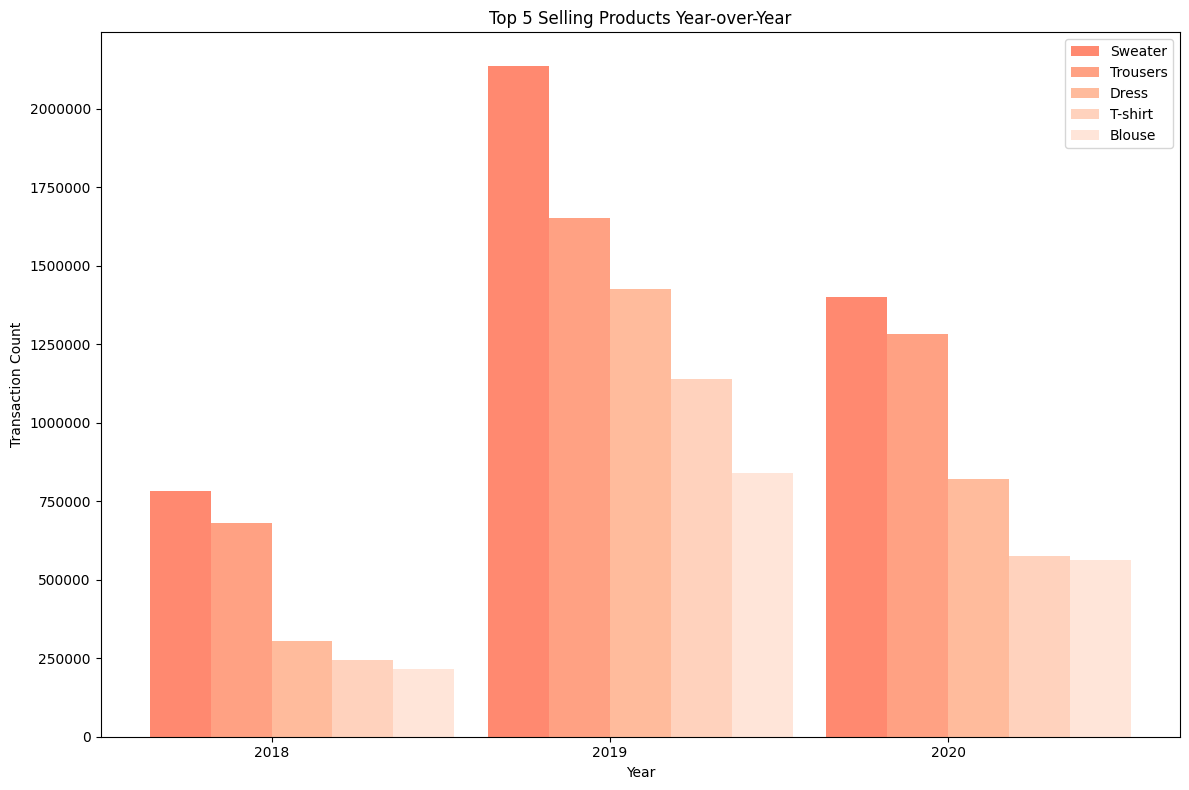

In [26]:
#Initializing a list to store the top 5 products for each year
top_5_products_yoy = []

#Iterating through each year and perform analysis
for year in merged_df['year'].unique():
    #Filtering data for the current year
    data_year = merged_df[merged_df['year'] == year]

    #Grouping by product and calculate total sales or transaction count
    top_products = data_year.groupby('product_type_name').size().reset_index(name='transaction_count')
    
    #Selecting the top 5 selling products for the current year
    top_5_products = top_products.nlargest(5, 'transaction_count')

    #Appending the results to the list
    top_5_products_yoy.append((year, top_5_products))

#Creating a custom red color palette
red_palette = ['#FF5733', '#FF794E', '#FF9E72', '#FFBFA1', '#FFDAC9']

#Creating a grouped bar chart for the top 5 products by year
fig, ax = plt.subplots(figsize=(12, 8))

#Preparing data for plotting
years = [year for year, _ in top_5_products_yoy]
product_names = [list(products['product_type_name']) for _, products in top_5_products_yoy]
transaction_counts = [list(products['transaction_count']) for _, products in top_5_products_yoy]

#Setting bar width and spacing
bar_width = 0.18  # Wider bar width
spacing = 0   # Reduced spacing

n = len(years)
bar_positions = [j - (bar_width + spacing) * 2 for j in range(n)]  # Adjusted bar positions

#Creating bars for each product using the custom red color palette
for i, product_name in enumerate(product_names[0]):
    x = [j + i * (bar_width + spacing) for j in bar_positions]
    y = [counts[i] for counts in transaction_counts]
    ax.bar(x, y, width=bar_width, label=f'{product_name}', alpha=0.7, color=red_palette[i])

#Setting x-axis ticks and labels
ax.set_xticks([j + (n / 2) * (bar_width + spacing) for j in bar_positions])
ax.set_xticklabels(years)
ax.set_xlabel('Year')
ax.set_ylabel('Transaction Count')
ax.set_title('Top 5 Selling Products Year-over-Year')
ax.legend()

#Formatting y-axis labels as integers (no scientific notation)
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.tight_layout()
plt.show()

In [27]:
del top_5_products_yoy
del data_year
del top_products
del top_5_products
del fig
gc.collect()

25

In [28]:
#Grouping data by 'Monetary_Segment' and 'Year' and count unique customers
segment_year_counts = merged_df.groupby(['Monetary_Segment', merged_df['t_dat'].dt.year])['customer_id'].nunique().reset_index()

#Calculating the YoY change
segment_year_counts['YoY Change'] = segment_year_counts.groupby('Monetary_Segment')['customer_id'].pct_change() * 100

segment_year_counts = segment_year_counts.rename(columns={'t_dat': 'year', 'customer_id': 'No. of customers'})

segment_year_counts


,Monetary_Segment,year,No. of customers,YoY Change
0,Low-Value Customer,2018,310501,NaN
1,Low-Value Customer,2019,654172,110.682735
2,Low-Value Customer,2020,541996,-17.147784
3,Medium-Value Customer,2018,394422,NaN
4,Medium-Value Customer,2019,764257,93.766321
5,Medium-Value Customer,2020,685775,-10.269059
6,High-Value Customer,2018,461596,NaN
7,High-Value Customer,2019,819230,77.477708
8,High-Value Customer,2020,693789,-15.312061


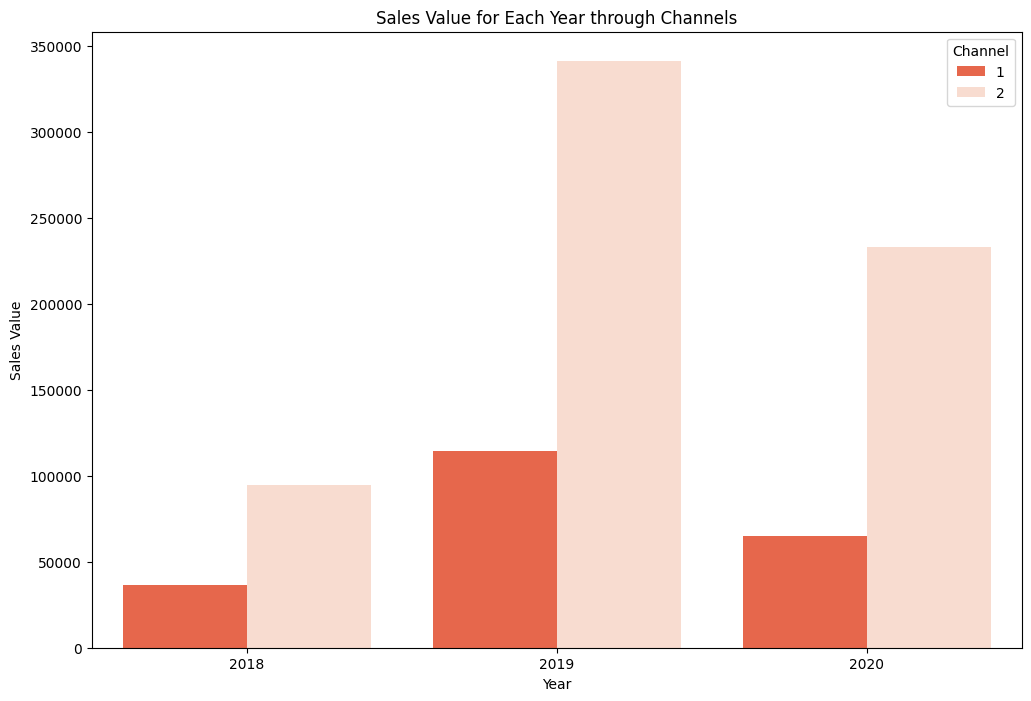

In [29]:
#Grouping the data by year and sales channel
sales_by_year_channel = merged_df.groupby(['year', 'sales_channel_id'])['price'].sum().reset_index()

#Defining a custom red color palette
red_palette = ['#FF5733', '#FFDAC9']

#Creating a Seaborn bar plot with the custom red color palette
plt.figure(figsize=(12, 8))
sns.set_palette(red_palette)  # Set the color palette
sns.barplot(data=sales_by_year_channel, x='year', y='price', hue='sales_channel_id')
plt.title('Sales Value for Each Year through Channels')
plt.xlabel('Year')
plt.ylabel('Sales Value')
plt.legend(title='Channel')
plt.show()

In [30]:
sales_by_year_channel

,year,sales_channel_id,price
0,2018,1,36388.889085
1,2018,2,94485.070220
2,2019,1,114339.123169
3,2019,2,341265.754797
4,2020,1,64954.815661
5,2020,2,233212.321119


<Figure size 1200x800 with 0 Axes>

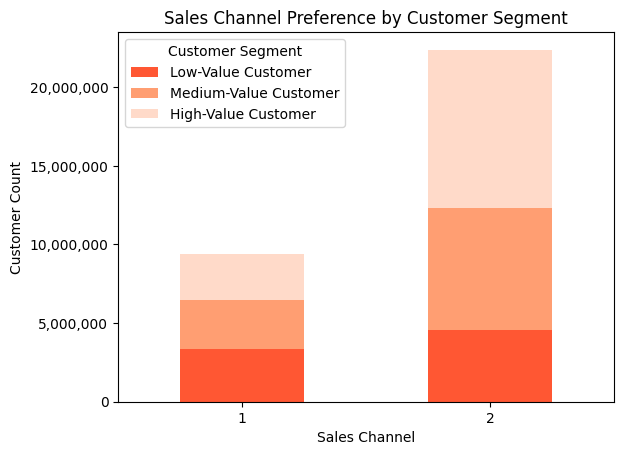

In [31]:
sales_channel_preference = merged_df.groupby(['sales_channel_id', 'Monetary_Segment'])['customer_id'].count().reset_index()
#Defining a custom red color palette
red_palette = ['#FF5733','#FF9E72', '#FFDAC9']

#Pivoting the data to prepare for the stacked bar chart
pivot_table = sales_channel_preference.pivot(index='sales_channel_id', columns='Monetary_Segment', values='customer_id')

#Creating the stacked bar chart using Matplotlib
plt.figure(figsize=(12, 8))
ax = pivot_table.plot(kind='bar', stacked=True, color=red_palette)
plt.title('Sales Channel Preference by Customer Segment')
plt.xlabel('Sales Channel')
plt.ylabel('Customer Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Customer Segment')

#Format y-axis labels as integers
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()


In [32]:
sales_channel_preference

,sales_channel_id,Monetary_Segment,customer_id
0,1,Low-Value Customer,3372268
1,1,Medium-Value Customer,3123854
2,1,High-Value Customer,2912340
3,2,Low-Value Customer,4576160
4,2,Medium-Value Customer,7754430
5,2,High-Value Customer,10049272


In [33]:
#Grouping data by product type and sales channel and calculate the total sales value
grouped_data = merged_df.groupby(['index_group_name', 'sales_channel_id'])['price'].sum().reset_index()

#Creating a custom red color palette
red_palette = ['#FF5733', '#FF794E', '#FF9E72', '#FFBFA1', '#FFDAC9']

#Creating sunburst chart
fig = px.sunburst(
    grouped_data,
    path=['index_group_name', 'sales_channel_id'],
    values='price',
    title='Sales Channel Preference by Product Type',
    color_discrete_sequence=red_palette,  # Set a custom red color palette
    labels={'price': 'Sales Value', 'index_group_name': 'Product Type'},
)

#Customizing the layout
fig.update_layout(
    margin=dict(t=50, l=50, r=50, b=50),  # Set margins
    title_font=dict(size=20),  # Adjust the title font size
)

#Displaying the sunburst chart
fig.show()

In [34]:
grouped_data

,index_group_name,sales_channel_id,price
0,Baby/Children,1,8298.601237
1,Baby/Children,2,15223.997136
2,Divided,1,36798.715475
3,Divided,2,152471.327542
4,Ladieswear,1,140660.065136
5,Ladieswear,2,446612.108085
6,Menswear,1,19755.640390
7,Menswear,2,28959.996441
8,Sport,1,10169.805678
9,Sport,2,25695.716932


In [35]:
del segment_year_counts
del sales_by_year_channel
del sales_channel_preference
del grouped_data
gc.collect()

4592

In [36]:
#Communication Frequency Analysis
frequency_distribution = merged_df['fashion_news_frequency'].value_counts()

#Create Customer Segments (e.g., age groups)
merged_df['AgeGroup'] = pd.cut(merged_df['age'], bins=[0,18, 30, 40, 50, 60, float('inf')],
                                   labels=['<18','18-30', '30-40', '40-50', '50-60', '60+'])

#Analyze Communication Frequency by Age Group
communication_by_age = merged_df.groupby('AgeGroup')['fashion_news_frequency'].value_counts()

#Spending Habits Analysis
spending_by_age_group = merged_df.groupby('AgeGroup')['price'].max()

In [37]:
communication_by_age = communication_by_age.reset_index()

In [38]:
communication_by_age[communication_by_age['fashion_news_frequency']=='NONE']

,AgeGroup,fashion_news_frequency,count
0,<18,NONE,149323
4,18-30,NONE,8579843
8,30-40,NONE,3337100
12,40-50,NONE,2852037
16,50-60,NONE,2464383
21,60+,NONE,542733


In [39]:
communication_by_age[communication_by_age['fashion_news_frequency']=='Regularly']

,AgeGroup,fashion_news_frequency,count
1,<18,Regularly,111072
5,18-30,Regularly,6034799
9,30-40,Regularly,2265903
13,40-50,Regularly,2339211
17,50-60,Regularly,2192440
20,60+,Regularly,640844


In [40]:
communication_by_age[communication_by_age['fashion_news_frequency']=='Monthly']

,AgeGroup,fashion_news_frequency,count
3,<18,Monthly,0
7,18-30,Monthly,3828
11,30-40,Monthly,2295
15,40-50,Monthly,1655
19,50-60,Monthly,1861
23,60+,Monthly,663


In [41]:
spending_by_age_group = spending_by_age_group.reset_index()

In [42]:
spending_by_age_group

,AgeGroup,price
0,<18,0.303390
1,18-30,0.591525
2,30-40,0.591525
3,40-50,0.591525
4,50-60,0.591525
5,60+,0.506780


In [43]:
custom_color_sequence = ['#FF5733', '#FF7043', '#FF8566', '#FFA07A', '#FFC0A9']

#Create the pie chart with the custom color sequence
fig = px.pie(spending_by_age_group, names='AgeGroup', values='price', hole=0.7, title="Spending by Age Group",
             color_discrete_sequence=custom_color_sequence)

#Show the donut chart
fig.show()

In [44]:
del communication_by_age
del spending_by_age_group
del fig
gc.collect()

1489

Hypothesis: Highest selling colors in each product category and is it significantly higher than others YoY basis.

Testing: Conduct ANOVA to compare the perceived color values of products across different departments.

In [45]:
#Group the data by department, color, and year and calculate the sales or revenue
grouped_data = merged_df.groupby(['department_name', 'perceived_colour_value_name', 'year'])['price'].sum().reset_index()

#Perform the ANOVA
result = stats.f_oneway(*[grouped_data[grouped_data['department_name'] == department]['price'] for department in grouped_data['department_name'].unique()])

#Define significance level (alpha)
alpha = 0.05

#Print the results
print("ANOVA F-statistic:", result.statistic)
print("P-value:", result.pvalue)

#Compare the p-value to the significance level
if result.pvalue < alpha:
    print("Reject the null hypothesis. There are significant differences in perceived color values between departments.")
else:
    print("Fail to reject the null hypothesis. There are no significant differences in perceived color values between departments.")

ANOVA F-statistic: 6.359940023287398
P-value: 2.345466277342273e-152
Reject the null hypothesis. There are significant differences in perceived color values between departments.


In [46]:
del grouped_data
del result
gc.collect()

0

Hypothesis: Customers in different age groups have significantly different purchase patterns in terms of product types.

Testing: Perform chi-squared tests to examine the association between age groups and product types.

In [47]:
#Create a contingency table of age groups and product types
contingency_table = pd.crosstab(merged_df['AgeGroup'], merged_df['product_type_name'])

#Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

#Define significance level (alpha)
alpha = 0.05

#Print the results
print("Chi-Squared Statistic:", chi2)
print("P-value:", p)

#Compare the p-value to the significance level
if p < alpha:
    print("Reject the null hypothesis. There is a significant association between age groups and product types.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between age groups and product types.")

Chi-Squared Statistic: 638533.2233544085
P-value: 0.0
Reject the null hypothesis. There is a significant association between age groups and product types.


In [48]:
del contingency_table
gc.collect()

0

Hypothesis: Club members (club_member_status = 'ACTIVE') have a higher customer lifetime value (CLV) compared to non-club members.

Testing: Conduct a t-test or ANOVA to compare CLV between club members and non-club members.

In [49]:
clv_data =merged_df.groupby('customer_id')['price'].sum().reset_index()
clv_data.rename(columns={'price': 'historical_CLV'}, inplace=True)

merged_df = merged_df.merge(clv_data, on='customer_id', how='left')

In [50]:
#Separate data into two groups: 'ACTIVE' club members and non-club members
club_members = merged_df[merged_df['club_member_status'] == 'ACTIVE']
non_club_members = merged_df[merged_df['club_member_status'] != 'ACTIVE']

#Perform a t-test to compare CLV between the two groups
t_stat, p_value = stats.ttest_ind(club_members['historical_CLV'], non_club_members['historical_CLV'])

#Define significance level (alpha)
alpha = 0.05

#Print the results
print("T-Statistic:", t_stat)
print("P-value:", p_value)

#Compare the p-value to the significance level
if p_value < alpha:
    print("Reject the null hypothesis. Club members with 'ACTIVE' status have a higher CLV.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in CLV.")

T-Statistic: 448.63280034609613
P-value: 0.0
Reject the null hypothesis. Club members with 'ACTIVE' status have a higher CLV.
